<small>
Copyright (c) 2017 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning From Basics to Practice
## by Andrew Glassner, https://dlbasics.com, http://glassner.com
------
## Chapter 19: Optimizers
### Notebook 4: Results of different optimizers

### Warning: Some of the plots in this notebook require a lot of computing, which can take a long time. Don't expect fast results!

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is still in the hacked-together form used to develop the figures, and is only lightly commented.

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop, Adamax

from keras.utils import np_utils
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sbn; sbn.set()

Using Theano backend.


In [3]:
# Make a File_Helper for saving and loading files.

save_files = True

import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
sys.path.insert(0, os.path.dirname(current_dir)) # path to parent dir
from DLBasics_Utilities import File_Helper
file_helper = File_Helper(save_files)

In [4]:
def make_data(num_samples=300, noise=0.2, random_state=42):
    (X, y) = make_moons(n_samples=num_samples, noise=noise, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    y_train = np_utils.to_categorical(y_train, number_of_classes)
    y_test = np_utils.to_categorical(y_test, number_of_classes)
    mms = MinMaxScaler()
    mms.fit(X)
    X_train = mms.transform(X_train)
    X_test = mms.transform(X_test)
    X = mms.transform(X)
    return (X, y, X_train, X_test, y_train, y_test)

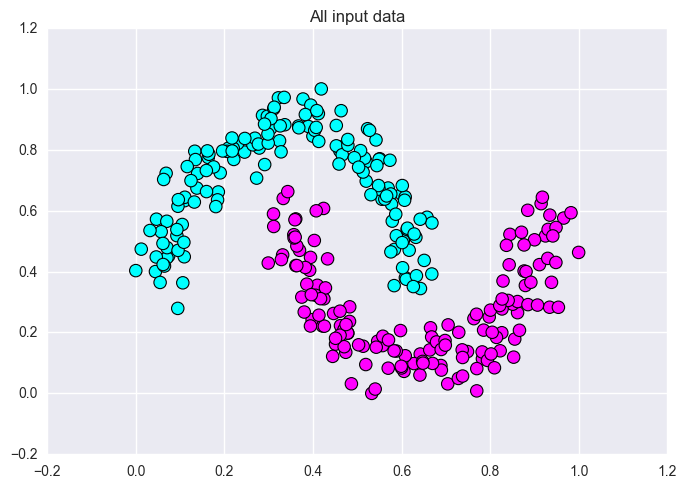

In [5]:
number_of_classes = 2
(X, y, X_train, X_test, y_train, y_test) = make_data(num_samples=300, noise=0.1, random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, s=80, lw=0.8, cmap='cool')
plt.title('All input data')
file_helper.save_figure('starting-error-data')
plt.show()

In [6]:
# www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
# plt.contourf throws warnings because np.reduce() has changed. It still works, through.
def plot_decision_boundary(filename, model):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    predictions = model.predict_classes(np.c_[xx.ravel(), yy.ravel()])
    #Z = np.asarray([np.argmax(z) for z in predictions])
    Z = predictions
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap='cool', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=80, lw=1, cmap='cool')#plt.cm.Spectral)
    save_figure(filename)
    plt.show()

In [7]:
# good saved results with 2, 3, 3, 2
def make_model():
    model = Sequential()
    model.add(Dense(12, input_dim=2, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(13, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(13, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(2, kernel_initializer='glorot_uniform', activation='softmax'))
    return model

In [8]:
(X, y, X_train, X_test, y_train, y_test) = make_data(num_samples=300, noise=0.1, random_state=42)

In [9]:
num_epochs = 20000

In [10]:
# search for a good starting seed
def search_opt():
    for s in range(10):
        np.random.seed(s)
        model = make_model()
        model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
                  optimizer=SGD(lr=0.01))
        history = model.fit(X_train, y_train, epochs=2000, batch_size=32, verbose=0)
        final_loss = history.history['loss'][-1]
        if s==0:
            best_loss = final_loss
            best_s = s
        if final_loss < best_loss:
            best_loss = final_loss
            best_s = s
        print("run s=",s," final loss=",final_loss)
    print("Best seed = ",best_s," with best final loss=",best_loss)

In [11]:
np.random.seed(2)
batchgd_model = make_model()
batchgd_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01))
history_batchgd = batchgd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=len(X_train), verbose=0)

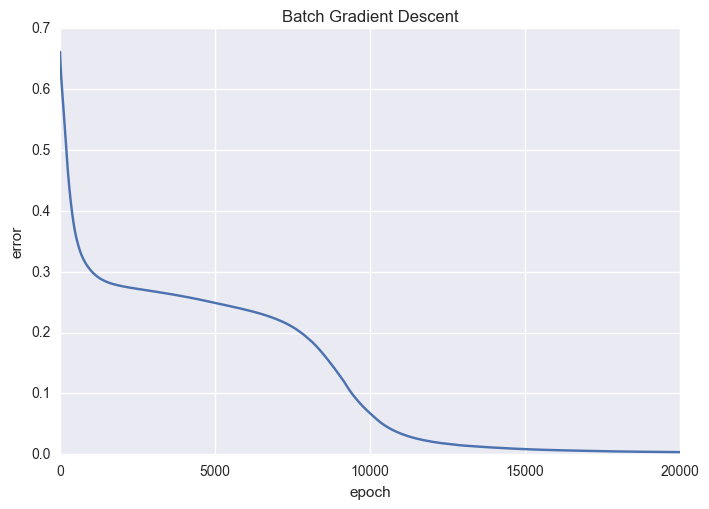

In [12]:
plt.plot(history_batchgd.history['loss'])
plt.title('Batch Gradient Descent')
plt.xlabel('epoch')
plt.ylabel('error')
file_helper.save_figure('loss-graph-BatchGD')
plt.show()

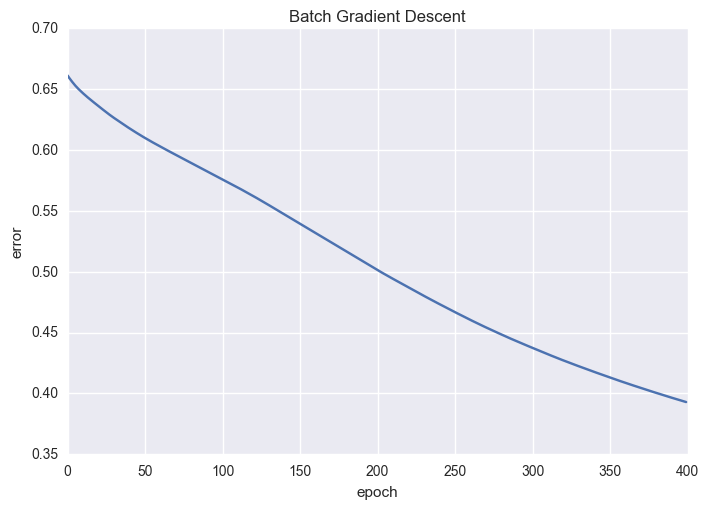

In [13]:
plt.plot(history_batchgd.history['loss'][:400])
plt.title('Batch Gradient Descent')
plt.xlabel('epoch')
plt.ylabel('error')
file_helper.save_figure('loss-graph-BatchGD-first-400')
plt.show()

In [14]:
np.random.seed(9)
sgd_model = make_model()
sgd_model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer=SGD(lr=0.01))
history_stochasticgd = sgd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=1, verbose=0)

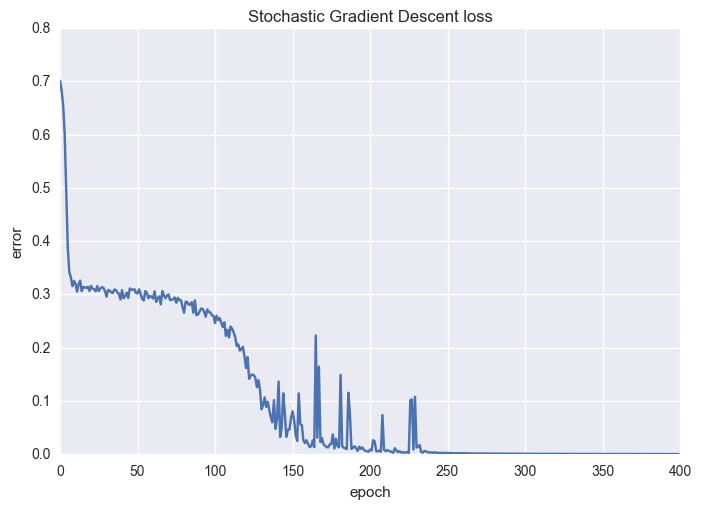

In [15]:
plt.plot(history_stochasticgd.history['loss'][:400])
plt.title('Stochastic Gradient Descent loss')
plt.xlabel('epoch')
plt.ylabel('error')
file_helper.save_figure('loss-graph-StochasticGD')
plt.show()

In [16]:
np.random.seed(9)
mini_batchgd_model = make_model()
mini_batchgd_model.compile(loss='binary_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01))
history_mini_batchgd = mini_batchgd_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

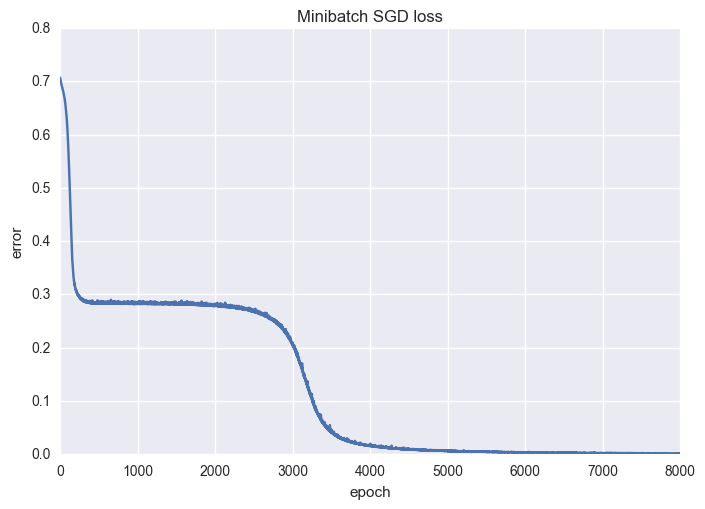

In [17]:
plt.plot(history_mini_batchgd.history['loss'][:8000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD loss')
file_helper.save_figure('loss-graph-mini-batch-SGD')
plt.show()

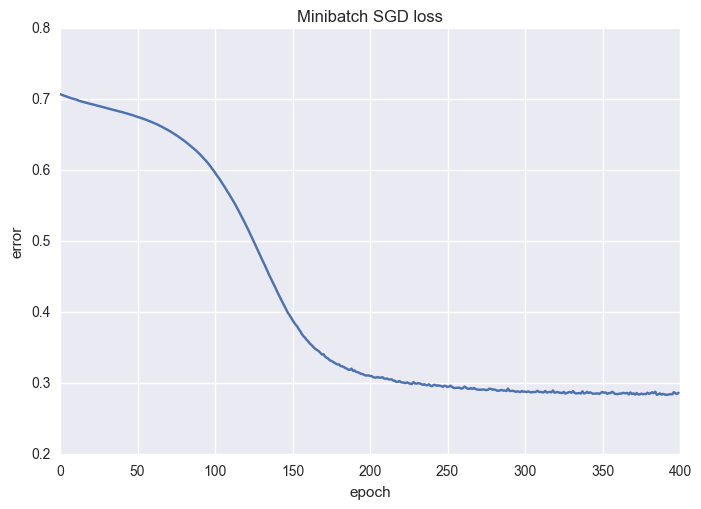

In [18]:
plt.plot(history_mini_batchgd.history['loss'][:400])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD loss')
file_helper.save_figure('loss-graph-mini-batch-SGD-first-400')
plt.show()

In [19]:
np.random.seed(9)
mini_batchgd_mom_model = make_model()
mini_batchgd_mom_model.compile(loss='binary_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01, momentum=0.9))
history_mini_batchgd_mom = mini_batchgd_mom_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

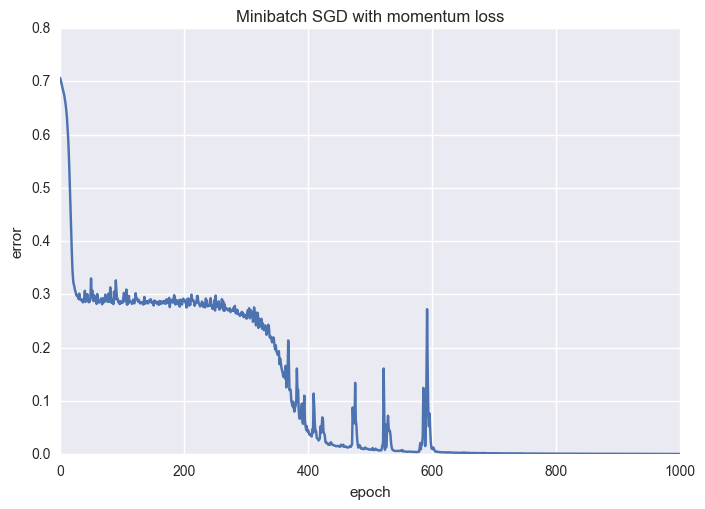

In [20]:
plt.plot(history_mini_batchgd_mom.history['loss'][:1000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD with momentum loss')
file_helper.save_figure('loss-graph-mini-batch-mom-SGD')
plt.show()

In [21]:
np.random.seed(8)
mini_batchgd_nest_model = make_model()
mini_batchgd_nest_model.compile(loss='binary_crossentropy', metrics=['accuracy'], 
              optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
history_mini_batchgd_nest = mini_batchgd_nest_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

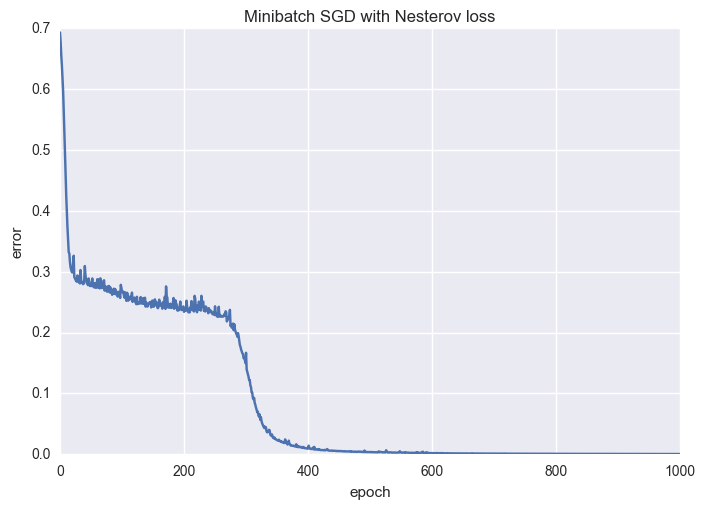

In [22]:
plt.plot(history_mini_batchgd_nest.history['loss'][:1000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Minibatch SGD with Nesterov loss')
file_helper.save_figure('loss-graph-mini-batch-nest-SGD')
plt.show()

In [23]:
np.random.seed(5)
rmsprop_model = make_model()
rmsprop_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=RMSprop(lr=0.01))
history_rmsprop = rmsprop_model.fit(X_train, y_train, epochs=num_epochs, batch_size=256, verbose=0)#num_epochs, batch_size=32, verbose=0)

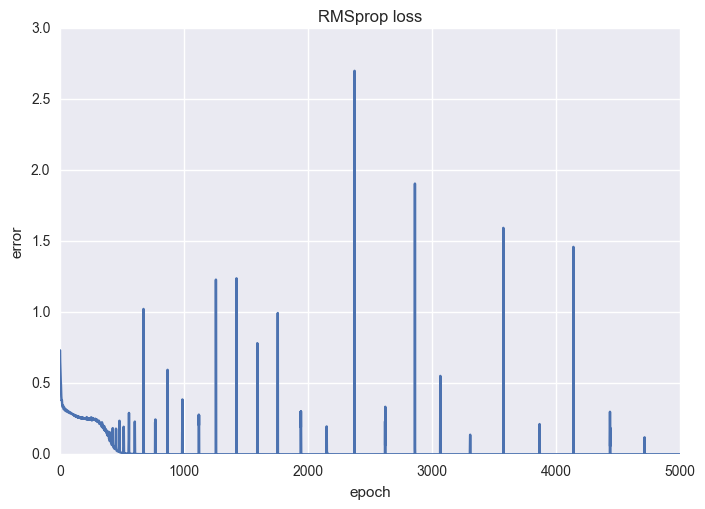

In [24]:
plt.plot(history_rmsprop.history['loss'][:5000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('RMSprop loss')
file_helper.save_figure('loss-graph-rmsprop')
plt.show()

In [25]:
np.random.seed(6)
adagrad_model = make_model()
adagrad_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adagrad(lr=0.01))
history_adagrad = adagrad_model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0)

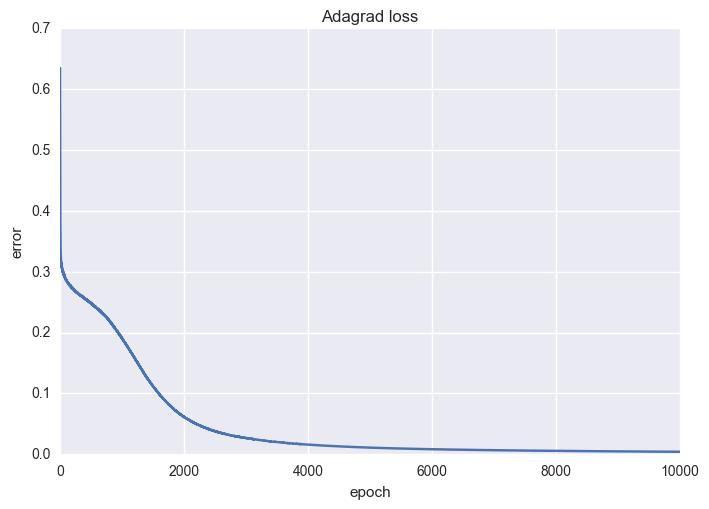

In [26]:
plt.plot(history_adagrad.history['loss'][:10000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Adagrad loss')
file_helper.save_figure('loss-graph-adagrad')
plt.show()

In [27]:
np.random.seed(9)
adadelta_model = make_model()
adadelta_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adadelta(lr=1.0))
history_adadelta = adadelta_model.fit(X_train, y_train, epochs=num_epochs, batch_size=16, verbose=0)

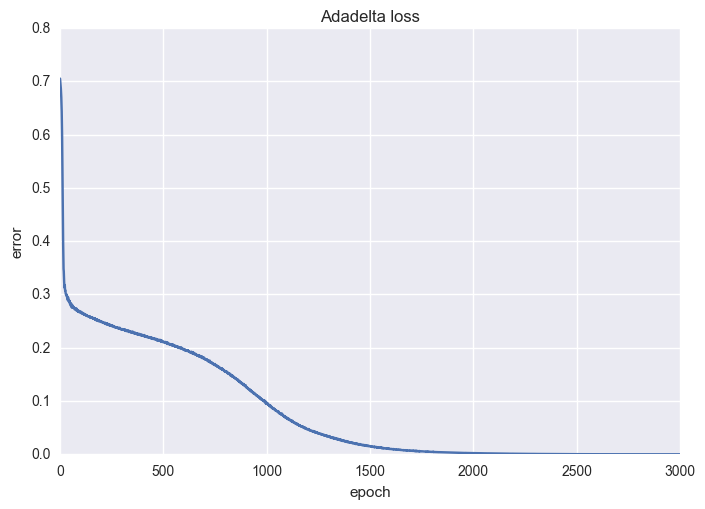

In [28]:
plt.plot(history_adadelta.history['loss'][:3000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Adadelta loss')
file_helper.save_figure('loss-graph-adadelta')
plt.show()

In [29]:
np.random.seed(2)
adam_model = make_model()
adam_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.001))
history_adam = adam_model.fit(X_train, y_train, epochs=num_epochs, batch_size=64, verbose=0)

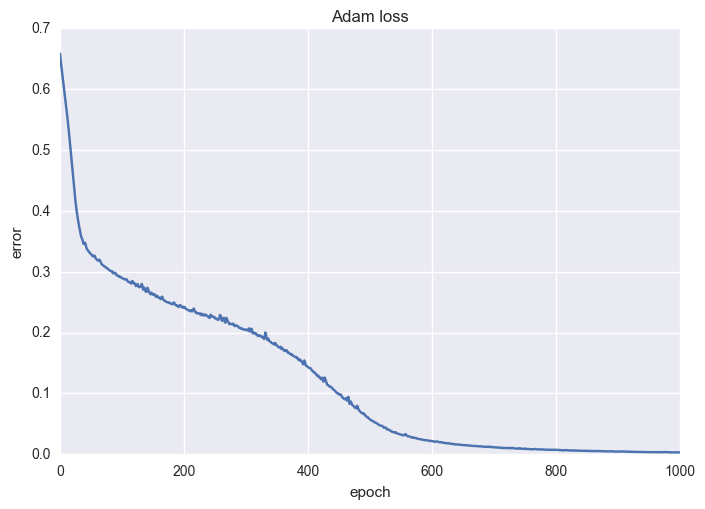

In [30]:
plt.plot(history_adam.history['loss'][:1000])
plt.xlabel('epoch')
plt.ylabel('error')
plt.title('Adam loss')
file_helper.save_figure('loss-graph-adam')
plt.show()

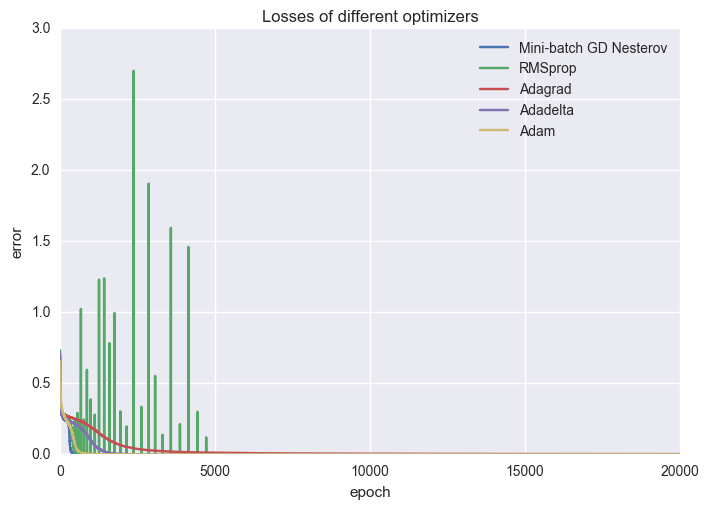

In [31]:
plt.plot(history_mini_batchgd_nest.history['loss'], label='Mini-batch GD Nesterov')
plt.plot(history_rmsprop.history['loss'], label='RMSprop')
plt.plot(history_adagrad.history['loss'], label='Adagrad')
plt.plot(history_adadelta.history['loss'], label='Adadelta')
plt.plot(history_adam.history['loss'], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set')
plt.show()

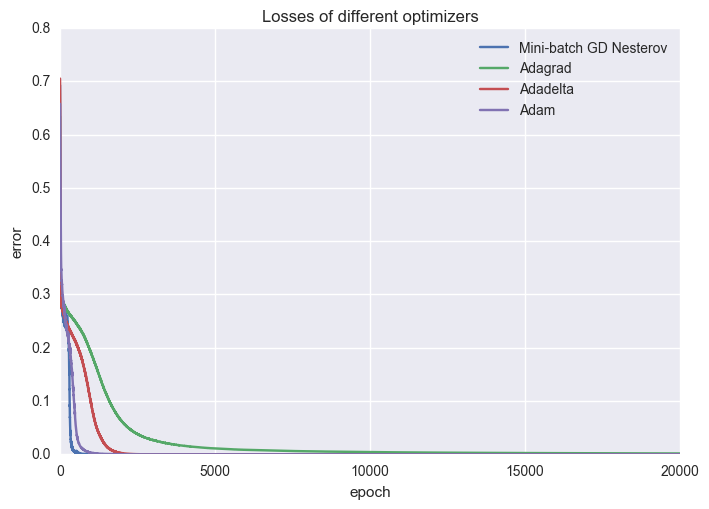

In [32]:
plt.plot(history_mini_batchgd_nest.history['loss'], label='Mini-batch GD Nesterov')
#plt.plot(history_rmsprop.history['loss'], label='RMSprop')
plt.plot(history_adagrad.history['loss'], label='Adagrad')
plt.plot(history_adadelta.history['loss'], label='Adadelta')
plt.plot(history_adam.history['loss'], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set-without-rms')
plt.show()

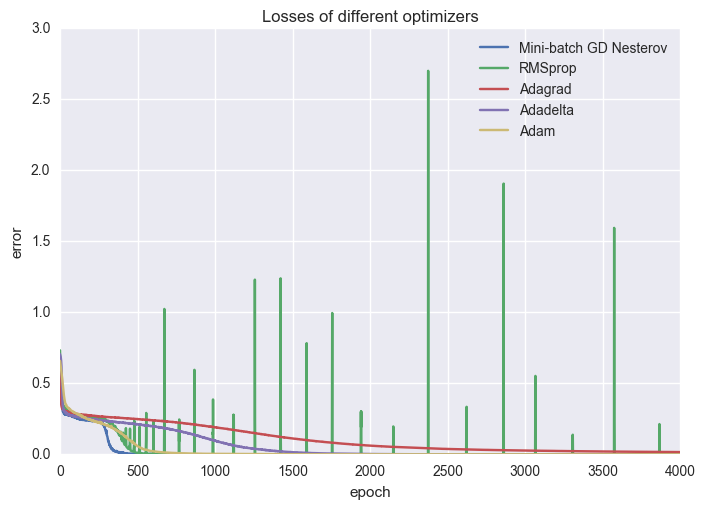

In [33]:
plot_limit = 4000
plt.plot(history_mini_batchgd_nest.history['loss'][:plot_limit], label='Mini-batch GD Nesterov')
plt.plot(history_rmsprop.history['loss'][:plot_limit], label='RMSprop')
plt.plot(history_adagrad.history['loss'][:plot_limit], label='Adagrad')
plt.plot(history_adadelta.history['loss'][:plot_limit], label='Adadelta')
plt.plot(history_adam.history['loss'][:plot_limit], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set-start')
plt.show()

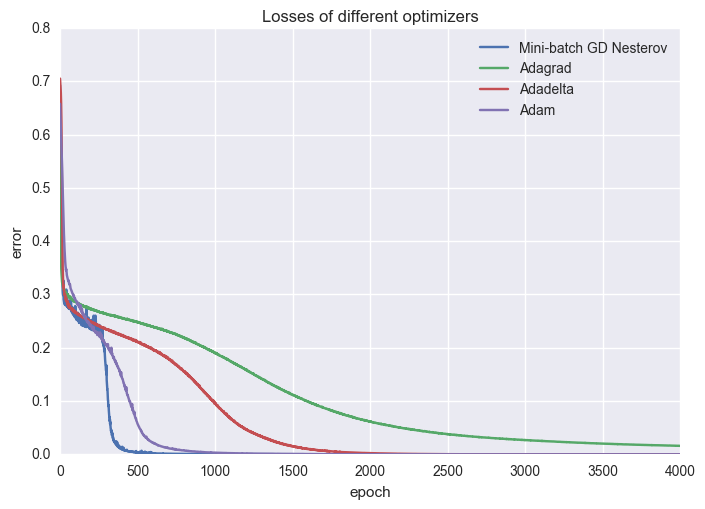

In [34]:
plt.plot(history_mini_batchgd_nest.history['loss'][:plot_limit], label='Mini-batch GD Nesterov')
#plt.plot(history_rmsprop.history['loss'][:plot_limit], label='RMSprop')
plt.plot(history_adagrad.history['loss'][:plot_limit], label='Adagrad')
plt.plot(history_adadelta.history['loss'][:plot_limit], label='Adadelta')
plt.plot(history_adam.history['loss'][:plot_limit], label='Adam')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend(loc='upper right')
plt.title('Losses of different optimizers')
file_helper.save_figure('loss-graphs-set-start-without-rms')
plt.show()